### Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut
import re
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
# from country_named_entity_recognition import find_countries
import pycountry
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.stats import pearsonr
import numpy as np
import os

/Users/toidi/anaconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns

### Procrssing

#### EYE-wit

In [16]:
# 1. Load the Excel dataset
df = pd.read_excel("data_cleaned_final_official.xlsx")

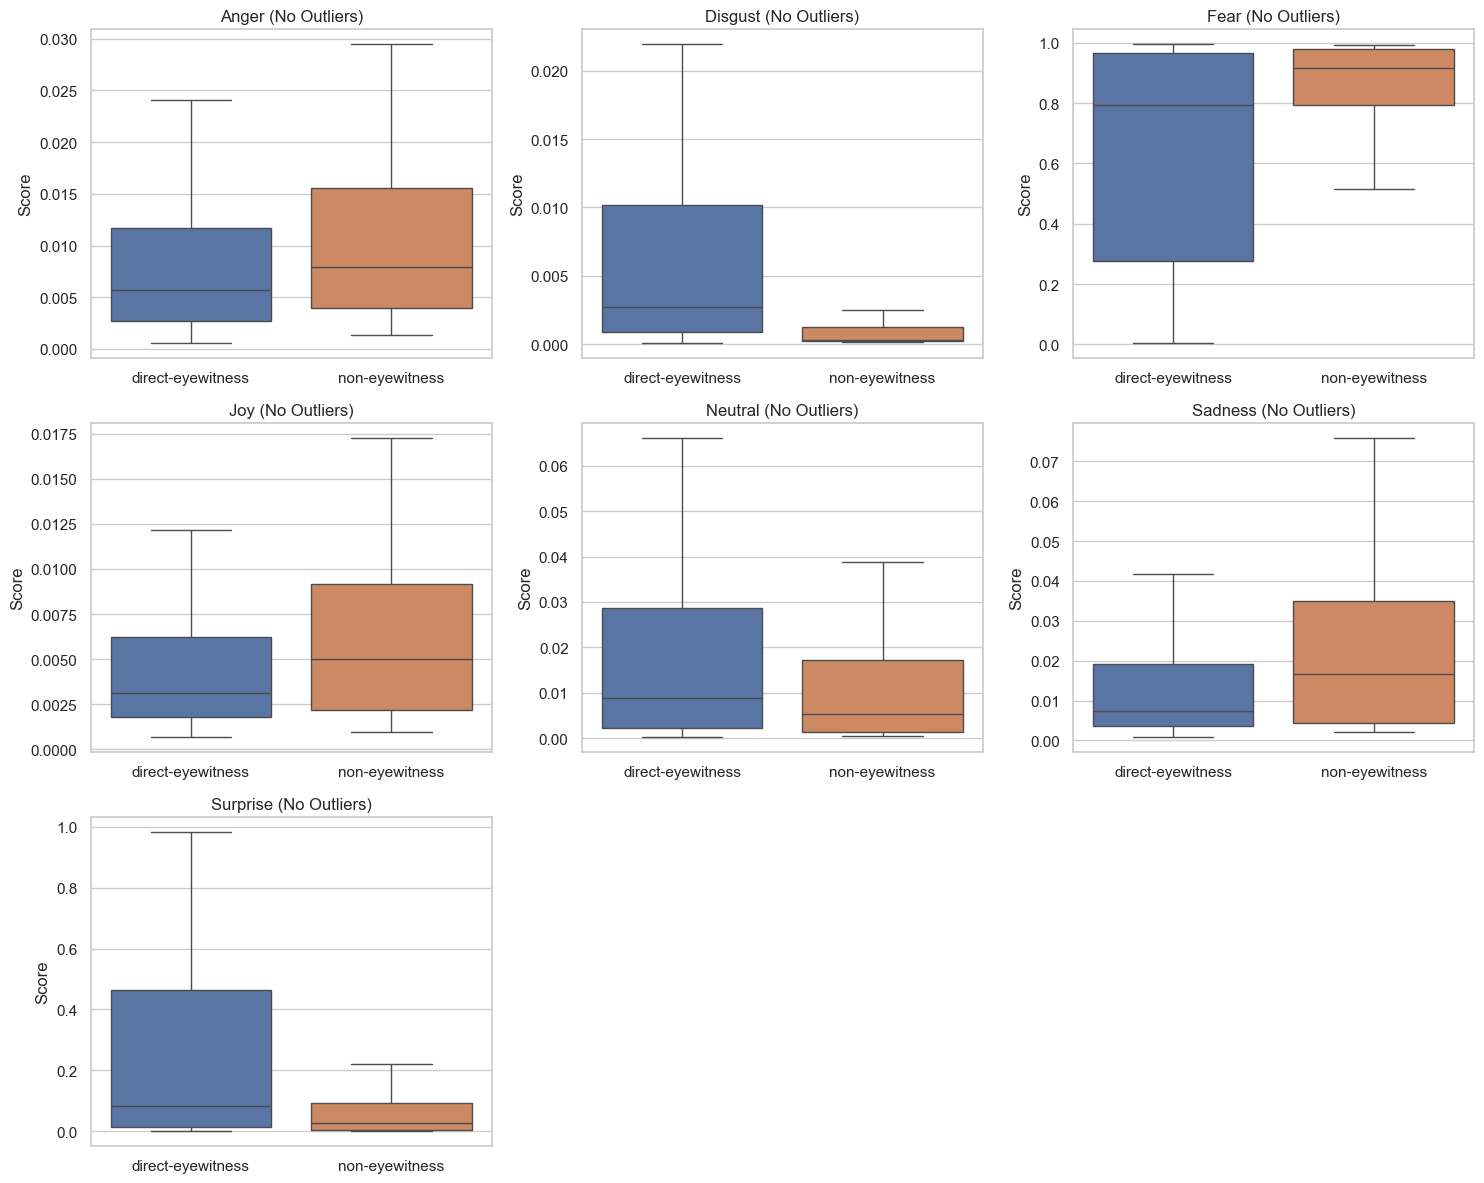

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Excel file
df = pd.read_excel("data_cleaned_final_official.xlsx")

# 2. Define emotion columns
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# 3. Filter for direct-eyewitness and non-eyewitness only
plot_df = df[df['label'].isin(['direct-eyewitness', 'non-eyewitness'])][['label'] + emotion_cols]

# 4. Convert label to category type
plot_df['label'] = plot_df['label'].astype('category')

# 5. Set seaborn style
sns.set(style="whitegrid")

# 6. Define subplot layout
n_cols = 3
n_rows = -(-len(emotion_cols) // n_cols)

# 7. Draw boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, emotion in enumerate(emotion_cols):
    ax = axes[idx]
    sns.boxplot(
        x='label',
        y=emotion,
        hue='label',
        data=plot_df,
        showfliers=False,
        ax=ax
    )
    ax.set_title(f'{emotion.capitalize()} (No Outliers)')
    ax.set_xlabel('')
    ax.set_ylabel('Score')
    
    # Only remove legend if it exists
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

# 8. Remove unused subplots
for j in range(len(emotion_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Eye-tiw t-test

In [20]:
!pip install tabulate

In [23]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from tabulate import tabulate
import numpy as np

# 1. Load Excel file
df = pd.read_excel("data_cleaned_final_official.xlsx")

# 2. Define emotion columns
emotion_cols = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# 3. Filter only direct-eyewitness and non-eyewitness
df = df[df['label'].isin(['direct-eyewitness', 'non-eyewitness'])]

# 4. Separate groups
direct = df[df['label'] == 'direct-eyewitness']
non = df[df['label'] == 'non-eyewitness']

# 5. Run t-tests and collect results
results = []
for emotion in emotion_cols:
    t_stat, p_val = ttest_ind(direct[emotion], non[emotion], equal_var=False)
    
    # Calculate means and standard deviations
    direct_mean = direct[emotion].mean()
    non_mean = non[emotion].mean()
    direct_sd = direct[emotion].std()  # Calculate SD for direct group
    non_sd = non[emotion].std()  # Calculate SD for non-eyewitness group
    
    # Calculate pooled standard deviation and Cohen's d
    pooled_sd = np.sqrt(((len(direct) - 1) * direct_sd**2 + (len(non) - 1) * non_sd**2) / (len(direct) + len(non) - 2))
    cohen_d = (direct_mean - non_mean) / pooled_sd  # Cohen's d calculation
    
    results.append({
        "Emotion": emotion,
        "M (Direct)": round(direct_mean, 3),
        "SD (Direct)": round(direct_sd, 3),  # Include SD for direct group
        "M (Non-Eyewitness)": round(non_mean, 3),
        "SD (Non-Eyewitness)": round(non_sd, 3),  # Include SD for non-eyewitness group
        "t": round(t_stat, 2),
        "p_raw": p_val,
        "Cohen's d": round(cohen_d, 3)  # Add Cohen's d to the result
    })

# 6. Convert to DataFrame
ttest_df = pd.DataFrame(results)

# 7. Holm correction
p_vals = ttest_df["p_raw"].values
_, p_corrected, _, _ = multipletests(p_vals, method='holm')

# 8. Format p-values and significance stars
def p_display(p):
    return "< .001" if p < 0.001 else f"{p:.3f}"

def stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

ttest_df["p"] = [p_display(p) for p in ttest_df["p_raw"]]
ttest_df["Sig."] = [stars(p) for p in ttest_df["p_raw"]]
ttest_df["p (Holm)"] = [p_display(p) for p in p_corrected]
ttest_df["Sig. (Holm)"] = [stars(p) for p in p_corrected]

# 9. Select and rename final columns
apa_table = ttest_df[["Emotion", "M (Direct)", "SD (Direct)", "M (Non-Eyewitness)", "SD (Non-Eyewitness)", "t", "p", "Sig.", "p (Holm)", "Sig. (Holm)", "Cohen's d"]]

# 10. Pretty-print APA table using tabulate
print(tabulate(
    apa_table,
    headers="keys",
    tablefmt="grid",
    showindex=False,
    floatfmt=".3f"
))


+-----------+--------------+---------------+----------------------+-----------------------+--------+--------+--------+------------+---------------+-------------+
| Emotion   |   M (Direct) |   SD (Direct) |   M (Non-Eyewitness) |   SD (Non-Eyewitness) |      t | p      | Sig.   | p (Holm)   | Sig. (Holm)   |   Cohen's d |
+===========+==============+===============+======================+=======================+========+========+========+============+===============+=============+
| anger     |        0.022 |         0.060 |                0.011 |                 0.009 |  2.530 | 0.012  | *      | 0.049      | *             |       0.221 |
+-----------+--------------+---------------+----------------------+-----------------------+--------+--------+--------+------------+---------------+-------------+
| disgust   |        0.015 |         0.046 |                0.001 |                 0.001 |  4.280 | < .001 | ***    | < .001     | ***           |       0.369 |
+-----------+--------------+

### plot

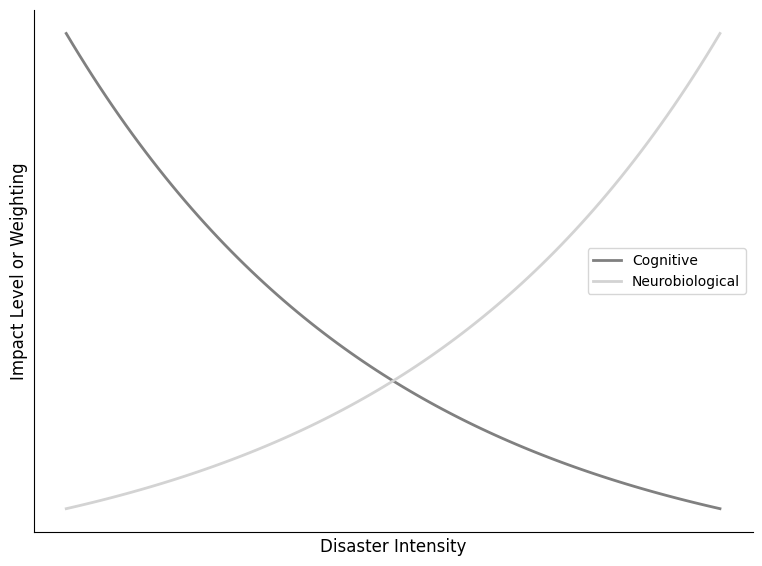

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for the cognitive and neurobiological curves with an extended range
x_extended = np.linspace(-3, 3, 100)
cognitive_extended = np.exp(-x_extended/3) * 20  # Adjusted for high value near 0
neurobiological_extended = np.exp(x_extended/3) * 20  # Adjusted for high value near 0

# Create the plot with extended range
plt.figure(figsize=(8, 6))

# Plot without grid and with adjusted curves
plt.plot(x_extended, cognitive_extended, label='Cognitive', color='gray', linewidth=2)
plt.plot(x_extended, neurobiological_extended, label='Neurobiological', color='lightgray', linewidth=2)

# Labeling the axes and the title
#plt.title('Proposed Emotional Impact Model', fontsize=14)
plt.xlabel('Disaster Intensity', fontsize=12)
plt.ylabel('Impact Level or Weighting', fontsize=12)

# Add annotations and labels
#plt.text(2, 0.1, 'Moderate Disaster', fontsize=12, ha='center')
#plt.text(2.5, 4, 'Extreme Event', fontsize=12, ha='center')

# Display legend
plt.legend()

# Remove grid and tighten layout
plt.grid(False)
plt.tight_layout()

# Remove the ticks (numbers) from the axes
plt.xticks([])
plt.yticks([])

# Keep only the left and bottom spines, remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add arrows for x and y axes
plt.gca().annotate('', xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle='->', lw=2))  # x-axis arrow
plt.gca().annotate('', xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle='->', lw=2))  # y-axis arrow

# Show the plot
plt.show()